In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Input, GRU, Dense, MaxPooling1D, Conv1D, Dropout, Lambda
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pickle
import os
import numpy as np
import config
import pandas as pd
import datetime

# Parameter and Path

In [2]:
NUM_UNITS = 64
DROPOUT = 0.75
RECURRENT_DROPOUT = 0.75
LEARNING_RATE = 1e-3
NUM_EPOCHS = 500
DECAY = 1e-3 / NUM_EPOCHS

In [3]:
data_path = r'D:\Workspace\video-mem\training_set/'

# CURRENT DIR
curr_path = os.path.abspath('')

# pre-trained glove
glove_path = r'./dataset/glove.6B/glove.6B.300d.txt'

embedding_tokenizer_path = r'./dataset/my_features/embeddings_tokenizer.pickle'
max_sequence_length_path = r'./dataset/my_features/max_sequence_length.txt'
EMBEDDINGS_TRAINING = True
EMBEDDING_DIM = 300

# Feature Directory
FEATURES_DIR = r"D:\Workspace\video-mem\training_set\Features"


## LOGS and CHECKPOINTS
RUN_NAME = datetime.datetime.now().strftime('run-%Y-%m-%d_%H-%M-%S')
LOG_DIR = os.path.join(curr_path, 'logs')
RUN_LOG_DIR = os.path.join(LOG_DIR, RUN_NAME)
RUN_LOG_FOLD_DIR = os.path.join(RUN_LOG_DIR, 'fold_{}')
RUN_CHECKPOINT_DIR = os.path.join(RUN_LOG_DIR, 'checkpoints')

In [4]:
LOG_DIR

'D:\\Workspace\\video-mem\\get_embedding\\logs'

# Utility Function for Training

In [5]:
def load_pretrained_word_vectors():
    """ Load pre-trained GLoVe vectors """

    print('[INFO] Loading word vectors...')
    embeddings_index = {}
    with open(glove_path, encoding='latin-1') as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, 'f', sep=' ')
            embeddings_index[word] = coefs
    print('[INFO] Found {:,} word vectors.'.format(len(embeddings_index)))
    return embeddings_index

In [6]:
def train_embeddings_network(train_captions, y_train, validation_captions, y_val, fold):

    print('[INFO] Loading word vectors')
    embeddings_index = load_pretrained_word_vectors()

    # CAPTIONS

    train_captions = train_captions.tolist()
    caption_words = list(set([ word for caption in train_captions for word in caption.split() ]))
    print('[INFO] {:,} words in the dev captions'.format(len(caption_words)))

    # VECTORIZATION

    print('[INFO] Vectorize the captions into a 2D integer tensor...')
    # Tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_captions)
    # # Save Tokenizer
    with open(embedding_tokenizer_path, 'wb') as f:
        pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

    # Sequences
    train_sequences = tokenizer.texts_to_sequences(train_captions)
    # Padding
    word_index = tokenizer.word_index
    MAX_NUM_WORDS = len(word_index)
    MAX_SEQUENCE_LENGTH = max([ len(caption.split()) for caption in train_captions ])
    # # Save
    with open(max_sequence_length_path, 'w') as f:
        f.write(str(MAX_SEQUENCE_LENGTH))

    # X and Y TRAIN
    X_train = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
    y_train = np.array(y_train)

    # X and Y validation
    print('[INFO] Preprocessing validation captions...')
    validation_captions = validation_captions.tolist()
    validation_sequences = tokenizer.texts_to_sequences(validation_captions)
    X_val = pad_sequences(validation_sequences, maxlen=MAX_SEQUENCE_LENGTH)
    y_val = np.array(y_val)

    ## TRAINING

    if EMBEDDINGS_TRAINING:

        print('[INFO] Creating the embeddings matrix...')
        # prepare embedding matrix
        num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
        embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
        for word, i in word_index.items():
            if i > MAX_NUM_WORDS:
                continue
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # words not found in embedding index will be all-zeros.
                embedding_matrix[i] = embedding_vector
        print('[INFO] Embedding Matrix\'s shape is {}'.format(embedding_matrix.shape))

        # MODEL

        # load pre-trained word embeddings into an Embedding layer
        # note that we set trainable = False so as to keep the embeddings fixed
        embedding_layer = Embedding(num_words,
                                    EMBEDDING_DIM,
                                    embeddings_initializer=Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False)

        print('[INFO] Training GRU model...')

        sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
        embedded_sequences = embedding_layer(sequence_input)
        x = GRU(
            units=NUM_UNITS, 
            dropout=DROPOUT, 
            recurrent_dropout=RECURRENT_DROPOUT,
            return_sequences=False,
        )(embedded_sequences)
        x = Dense(1024, activation="relu")(x)
        x = Dropout(0.25, seed=42)(x)
        x = Dense(512, activation="relu")(x)
        x = Dropout(0.25, seed=42)(x)
        x = Dense(256, activation="relu")(x)
        x = Dropout(0.25, seed=42)(x)
        preds = Dense(1, activation='sigmoid')(x)
        model = Model(sequence_input, preds)

        print('[INFO] Model\'s Summary')
        print(model.summary())

        # COMPILE

        print('[INFO] Compiling model...')

        # Optimizer
        opt = Adam(lr=LEARNING_RATE, decay=DECAY)

        model.compile(
            loss='mean_squared_error',
            optimizer=opt,
            metrics=['mse', 'mae', 'mape'],
        )

        # FIT

        print('[INFO] Fitting model...')

        tensorboard = TensorBoard(log_dir=RUN_LOG_FOLD_DIR.format(fold)) # config.RUN_LOG_DIR
        
        checkpoints = ModelCheckpoint(
        os.path.join(
            RUN_CHECKPOINT_DIR,
            'weights-fold_' + str(fold) + '-{epoch:02d}-{val_loss:.10f}.hdf5'),
        monitor='val_mse', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        
        H = model.fit(X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=NUM_EPOCHS,
            shuffle=False,
            batch_size=32,
            use_multiprocessing=True,
            workers=8,
            callbacks=[
                tensorboard,
                checkpoints,
                ]
        )

        # PLOT TRAINING LOSS vs ACCURACY

        plt.style.use("ggplot")
        plt.figure()
        plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
        plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
        plt.plot(np.arange(0, NUM_EPOCHS), H.history["mse"], label="train_MSE")
        plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_mse"], label="val_MSE")
        # plt.plot(np.arange(0, config.NUM_EPOCHS), H.history["mean_absolute_error"], label="train_MAE")
        # plt.plot(np.arange(0, config.NUM_EPOCHS), H.history["val_mean_absolute_error"], label="val_MAE")
        # # plt.plot(np.arange(0, config.NUM_EPOCHS), H.history["mean_absolute_percentage_error"], label="train_MAPE")
        # plt.plot(np.arange(0, config.NUM_EPOCHS), H.history["val_mean_absolute_percentage_error"], label="val_MAPE")
        plt.title("Training Loss and MSE")
        plt.xlabel("Epoch #")
        plt.ylabel("Loss/MSE")
        plt.legend()
        plt.savefig('{}/embeddings_loss_vs_MSE.png'.format(RUN_LOG_FOLD_DIR.format(fold)))

    ## LOAD MODEL

    else:

        model_name = config.EMBEDDINGS_MODEL[config.TARGET_SHORT_NAME]
        print('[INFO] Loading model {}...'.format(model_name))
        model = load_model(model_name)

    print('[INFO] Predicting values...')
    predicted = model.predict(X_val).flatten()

    return predicted

In [7]:
def fit_predict_with_embeddings(test_captions):

    # Load Tokenizer
    print('[INFO] Loading Tokenizer...')
    with open(config.embedding_tokenizer_path, 'rb') as f:
        tokenizer = pickle.load(f)

    # Load MAX_SEQUENCE_LENGTH
    with open(max_sequence_length_path) as f:
        MAX_SEQUENCE_LENGTH = int(f.read())
    print('[INFO] MAX_SEQUENCE_LENGTH={}'.format(MAX_SEQUENCE_LENGTH))

    model_name = config.EMBEDDINGS_MODEL[config.TARGET_SHORT_NAME]
    print('[INFO] Loading model {}...'.format(model_name))
    model = load_model(model_name)

    print('[INFO] Preprocessing validation captions...')
    test_captions = test_captions.tolist()
    test_sequences = tokenizer.texts_to_sequences(test_captions)
    X_test = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

    print('[INFO] Predicting values...')
    predicted = model.predict(X_test).flatten()

    return predicted

# Data Loading

In [8]:
score_data = pd.read_csv(data_path+'scores_v2.csv')

In [9]:
score_data.head()

,video_id,video_url,ann_1,ann_2,part_1_scores,part_2_scores
0,8,https://mtc.cdn.vine.co/r/videos_h264high/9EB0...,20,7,0.75,0.57
1,26,https://mtc.cdn.vine.co/r/videos_h264high/A8B3...,23,7,0.87,0.43
2,33,https://mtc.cdn.vine.co/r/videos/267829AEFA128...,26,4,0.69,0.75
3,46,https://mtc.cdn.vine.co/r/videos_h264high/B974...,23,7,0.87,0.57
4,64,https://mtc.cdn.vine.co/r/videos_h264high/C4D6...,19,9,0.84,0.56


In [10]:
human_caption_data = pd.read_csv(data_path+'text_descriptions.csv')

In [11]:
human_caption_data.head()

,video_id,video_url,description
0,8,https://mtc.cdn.vine.co/r/videos_h264high/9EB0...,2 men on a stage hug and walk away
1,8,https://mtc.cdn.vine.co/r/videos_h264high/9EB0...,two young man are standing on a stage embracin...
2,26,https://mtc.cdn.vine.co/r/videos_h264high/A8B3...,deadpool drinking from a cup
3,26,https://mtc.cdn.vine.co/r/videos_h264high/A8B3...,persons in costumes dance
4,33,https://mtc.cdn.vine.co/r/videos/267829AEFA128...,a soccer player shoots a ball into a tiny goal...


In [12]:
score_and_caption = pd.merge(left = score_data, right = human_caption_data, how = 'inner', on = ['video_id'])[['video_id', 'part_1_scores', 'part_2_scores', 'description']]
score_and_caption.columns = ['video_id', 'short-term_memorability', 'long-term_memorability', 'description']
score_and_caption.head(10)

,video_id,short-term_memorability,long-term_memorability,description
0,8,0.75,0.57,2 men on a stage hug and walk away
1,8,0.75,0.57,two young man are standing on a stage embracin...
2,26,0.87,0.43,deadpool drinking from a cup
3,26,0.87,0.43,persons in costumes dance
4,33,0.69,0.75,a soccer player shoots a ball into a tiny goal...
5,33,0.69,0.75,soccer ball rolling into a small goal on a soc...
6,46,0.87,0.57,multiple chinese persons dance onstage
7,46,0.87,0.57,on a podium 5 person perform a dance
8,64,0.84,0.56,an asian man in a clothing store embraces an o...
9,64,0.84,0.56,an asian man in cloth shop opens his jacket an...


In [13]:
# creating the sub id of an entry
video_id_list = score_and_caption['video_id'].tolist()
sub_id_list = list()
temp = list()
for item in video_id_list:
    sub_id_list.append(temp.count(item))
    temp.append(item)
score_and_caption['sub_id'] = sub_id_list
score_and_caption.head()

,video_id,short-term_memorability,long-term_memorability,description,sub_id
0,8,0.75,0.57,2 men on a stage hug and walk away,0
1,8,0.75,0.57,two young man are standing on a stage embracin...,1
2,26,0.87,0.43,deadpool drinking from a cup,0
3,26,0.87,0.43,persons in costumes dance,1
4,33,0.69,0.75,a soccer player shoots a ball into a tiny goal...,0


In [14]:
x = score_and_caption['description']
x.head()

0                   2 men on a stage hug and walk away
1    two young man are standing on a stage embracin...
2                         deadpool drinking from a cup
3                            persons in costumes dance
4    a soccer player shoots a ball into a tiny goal...
Name: description, dtype: object

In [15]:
Y_short = score_and_caption['short-term_memorability']
Y_long = score_and_caption['long-term_memorability']

#### Short-term data spliting

In [16]:
x_short_train, x_short_val, y_short_train, y_short_val = train_test_split(
    x,
    Y_short,
    test_size=0.125,
    random_state=42)

In [17]:
x_short_val

382     Young women talking about studying for finals ...
632     Black car takes off; leaves dust flying and ki...
1670    In a house, a boy is playing an electric piano...
211     a man sitting in a driving cabrio car is givin...
1488    A Neiman-Marcus shopping bag next to a vase of...
                              ...                        
2011    Three people singing with a blond woman with l...
829     A tiny brown dog grapples with a tennis ball o...
124               a man is making the hair of another man
1813    A woman wearing a blue dress dances as she com...
185                    a thickly african woman is singing
Name: description, Length: 274, dtype: object

#### Long-term data spliting

In [18]:
x_long_train, X_long_val, y_long_train, y_long_val = train_test_split(
    x,
    Y_long,
    test_size=0.125,
    random_state=42)

# Training

[INFO] Loading word vectors
[INFO] Loading word vectors...
[INFO] Found 399,955 word vectors.
[INFO] 4,679 words in the dev captions
[INFO] Vectorize the captions into a 2D integer tensor...
[INFO] Preprocessing validation captions...
[INFO] Creating the embeddings matrix...
[INFO] Embedding Matrix's shape is (3468, 300)
[INFO] Training GRU model...
[INFO] Model's Summary
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 86)]              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 86, 300)           1040400   
_________________________________________________________________
gru_5 (GRU)                  (None, 64)                70272     
_________________________________________________________________
dense_20 (Dense)             (None, 1024)              66560     
______________

Epoch 34/500
60/60 [==============================] - ETA: 0s - loss: 0.0077 - mse: 0.0077 - mae: 0.0709 - mape: 8.8576
Epoch 00034: val_mse did not improve from 0.00801
60/60 [==============================] - 19s 310ms/step - loss: 0.0077 - mse: 0.0077 - mae: 0.0709 - mape: 8.8576 - val_loss: 0.0081 - val_mse: 0.0081 - val_mae: 0.0722 - val_mape: 9.2292
Epoch 35/500
60/60 [==============================] - ETA: 0s - loss: 0.0075 - mse: 0.0075 - mae: 0.0702 - mape: 8.7572
Epoch 00035: val_mse did not improve from 0.00801
60/60 [==============================] - 21s 342ms/step - loss: 0.0075 - mse: 0.0075 - mae: 0.0702 - mape: 8.7572 - val_loss: 0.0081 - val_mse: 0.0081 - val_mae: 0.0719 - val_mape: 9.2266
Epoch 36/500
60/60 [==============================] - ETA: 0s - loss: 0.0073 - mse: 0.0073 - mae: 0.0691 - mape: 8.6192
Epoch 00036: val_mse did not improve from 0.00801
60/60 [==============================] - 19s 311ms/step - loss: 0.0073 - mse: 0.0073 - mae: 0.0691 - mape: 8.6192 

Epoch 79/500
60/60 [==============================] - ETA: 0s - loss: 0.0062 - mse: 0.0062 - mae: 0.0628 - mape: 7.8130
Epoch 00079: val_mse did not improve from 0.00787
60/60 [==============================] - 17s 285ms/step - loss: 0.0062 - mse: 0.0062 - mae: 0.0628 - mape: 7.8130 - val_loss: 0.0087 - val_mse: 0.0087 - val_mae: 0.0750 - val_mape: 9.2836
Epoch 80/500
60/60 [==============================] - ETA: 0s - loss: 0.0062 - mse: 0.0062 - mae: 0.0630 - mape: 7.8368
Epoch 00080: val_mse did not improve from 0.00787
60/60 [==============================] - 18s 304ms/step - loss: 0.0062 - mse: 0.0062 - mae: 0.0630 - mape: 7.8368 - val_loss: 0.0083 - val_mse: 0.0083 - val_mae: 0.0731 - val_mape: 9.1559
Epoch 81/500
60/60 [==============================] - ETA: 0s - loss: 0.0059 - mse: 0.0059 - mae: 0.0620 - mape: 7.7106
Epoch 00081: val_mse did not improve from 0.00787
60/60 [==============================] - 19s 316ms/step - loss: 0.0059 - mse: 0.0059 - mae: 0.0620 - mape: 7.7106 

Epoch 102/500
60/60 [==============================] - ETA: 0s - loss: 0.0055 - mse: 0.0055 - mae: 0.0580 - mape: 7.1965
Epoch 00102: val_mse did not improve from 0.00787
60/60 [==============================] - 17s 283ms/step - loss: 0.0055 - mse: 0.0055 - mae: 0.0580 - mape: 7.1965 - val_loss: 0.0083 - val_mse: 0.0083 - val_mae: 0.0735 - val_mape: 9.1323
Epoch 103/500
60/60 [==============================] - ETA: 0s - loss: 0.0055 - mse: 0.0055 - mae: 0.0589 - mape: 7.2985
Epoch 00103: val_mse did not improve from 0.00787
60/60 [==============================] - 17s 288ms/step - loss: 0.0055 - mse: 0.0055 - mae: 0.0589 - mape: 7.2985 - val_loss: 0.0082 - val_mse: 0.0082 - val_mae: 0.0723 - val_mape: 9.0250
Epoch 104/500
60/60 [==============================] - ETA: 0s - loss: 0.0054 - mse: 0.0054 - mae: 0.0583 - mape: 7.2015
Epoch 00104: val_mse did not improve from 0.00787
60/60 [==============================] - 18s 292ms/step - loss: 0.0054 - mse: 0.0054 - mae: 0.0583 - mape: 7.20

Epoch 125/500
60/60 [==============================] - ETA: 0s - loss: 0.0049 - mse: 0.0049 - mae: 0.0559 - mape: 6.9182
Epoch 00125: val_mse did not improve from 0.00787
60/60 [==============================] - 20s 325ms/step - loss: 0.0049 - mse: 0.0049 - mae: 0.0559 - mape: 6.9182 - val_loss: 0.0082 - val_mse: 0.0082 - val_mae: 0.0727 - val_mape: 9.0600
Epoch 126/500
60/60 [==============================] - ETA: 0s - loss: 0.0051 - mse: 0.0051 - mae: 0.0564 - mape: 6.9648
Epoch 00126: val_mse did not improve from 0.00787
60/60 [==============================] - 18s 294ms/step - loss: 0.0051 - mse: 0.0051 - mae: 0.0564 - mape: 6.9648 - val_loss: 0.0082 - val_mse: 0.0082 - val_mae: 0.0722 - val_mape: 9.0620
Epoch 127/500
60/60 [==============================] - ETA: 0s - loss: 0.0049 - mse: 0.0049 - mae: 0.0555 - mape: 6.8610
Epoch 00127: val_mse did not improve from 0.00787
60/60 [==============================] - 18s 302ms/step - loss: 0.0049 - mse: 0.0049 - mae: 0.0555 - mape: 6.86

Epoch 147/500
60/60 [==============================] - ETA: 0s - loss: 0.0044 - mse: 0.0044 - mae: 0.0524 - mape: 6.4738
Epoch 00147: val_mse did not improve from 0.00767
60/60 [==============================] - 19s 323ms/step - loss: 0.0044 - mse: 0.0044 - mae: 0.0524 - mape: 6.4738 - val_loss: 0.0085 - val_mse: 0.0085 - val_mae: 0.0733 - val_mape: 9.2242
Epoch 148/500
60/60 [==============================] - ETA: 0s - loss: 0.0044 - mse: 0.0044 - mae: 0.0528 - mape: 6.4999
Epoch 00148: val_mse did not improve from 0.00767
60/60 [==============================] - 18s 302ms/step - loss: 0.0044 - mse: 0.0044 - mae: 0.0528 - mape: 6.4999 - val_loss: 0.0081 - val_mse: 0.0081 - val_mae: 0.0712 - val_mape: 8.9333
Epoch 149/500
60/60 [==============================] - ETA: 0s - loss: 0.0044 - mse: 0.0044 - mae: 0.0527 - mape: 6.4961
Epoch 00149: val_mse did not improve from 0.00767
60/60 [==============================] - 18s 298ms/step - loss: 0.0044 - mse: 0.0044 - mae: 0.0527 - mape: 6.49

Epoch 170/500
60/60 [==============================] - ETA: 0s - loss: 0.0039 - mse: 0.0039 - mae: 0.0491 - mape: 6.0587
Epoch 00170: val_mse did not improve from 0.00767
60/60 [==============================] - 19s 309ms/step - loss: 0.0039 - mse: 0.0039 - mae: 0.0491 - mape: 6.0587 - val_loss: 0.0084 - val_mse: 0.0084 - val_mae: 0.0729 - val_mape: 9.1353
Epoch 171/500
60/60 [==============================] - ETA: 0s - loss: 0.0042 - mse: 0.0042 - mae: 0.0512 - mape: 6.3091
Epoch 00171: val_mse did not improve from 0.00767
60/60 [==============================] - 18s 306ms/step - loss: 0.0042 - mse: 0.0042 - mae: 0.0512 - mape: 6.3091 - val_loss: 0.0088 - val_mse: 0.0088 - val_mae: 0.0750 - val_mape: 9.3333
Epoch 172/500
60/60 [==============================] - ETA: 0s - loss: 0.0040 - mse: 0.0040 - mae: 0.0502 - mape: 6.1779
Epoch 00172: val_mse did not improve from 0.00767
60/60 [==============================] - 19s 317ms/step - loss: 0.0040 - mse: 0.0040 - mae: 0.0502 - mape: 6.17

Epoch 193/500
60/60 [==============================] - ETA: 0s - loss: 0.0036 - mse: 0.0036 - mae: 0.0476 - mape: 5.8317
Epoch 00193: val_mse did not improve from 0.00767
60/60 [==============================] - 18s 306ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0476 - mape: 5.8317 - val_loss: 0.0088 - val_mse: 0.0088 - val_mae: 0.0737 - val_mape: 9.2435
Epoch 194/500
60/60 [==============================] - ETA: 0s - loss: 0.0039 - mse: 0.0039 - mae: 0.0495 - mape: 6.1051
Epoch 00194: val_mse did not improve from 0.00767
60/60 [==============================] - 19s 317ms/step - loss: 0.0039 - mse: 0.0039 - mae: 0.0495 - mape: 6.1051 - val_loss: 0.0086 - val_mse: 0.0086 - val_mae: 0.0732 - val_mape: 9.1822
Epoch 195/500
60/60 [==============================] - ETA: 0s - loss: 0.0037 - mse: 0.0037 - mae: 0.0479 - mape: 5.8952
Epoch 00195: val_mse did not improve from 0.00767
60/60 [==============================] - 18s 306ms/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0479 - mape: 5.89

Epoch 216/500
60/60 [==============================] - ETA: 0s - loss: 0.0035 - mse: 0.0035 - mae: 0.0460 - mape: 5.6524
Epoch 00216: val_mse did not improve from 0.00767
60/60 [==============================] - 18s 305ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0460 - mape: 5.6524 - val_loss: 0.0088 - val_mse: 0.0088 - val_mae: 0.0739 - val_mape: 9.1101
Epoch 217/500
60/60 [==============================] - ETA: 0s - loss: 0.0035 - mse: 0.0035 - mae: 0.0465 - mape: 5.7222
Epoch 00217: val_mse did not improve from 0.00767
60/60 [==============================] - 18s 306ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0465 - mape: 5.7222 - val_loss: 0.0091 - val_mse: 0.0091 - val_mae: 0.0758 - val_mape: 9.3634
Epoch 218/500
60/60 [==============================] - ETA: 0s - loss: 0.0035 - mse: 0.0035 - mae: 0.0465 - mape: 5.7243
Epoch 00218: val_mse did not improve from 0.00767
60/60 [==============================] - 18s 302ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0465 - mape: 5.72

Epoch 239/500
60/60 [==============================] - ETA: 0s - loss: 0.0033 - mse: 0.0033 - mae: 0.0451 - mape: 5.5551
Epoch 00239: val_mse did not improve from 0.00767
60/60 [==============================] - 18s 304ms/step - loss: 0.0033 - mse: 0.0033 - mae: 0.0451 - mape: 5.5551 - val_loss: 0.0089 - val_mse: 0.0089 - val_mae: 0.0749 - val_mape: 9.3349
Epoch 240/500
60/60 [==============================] - ETA: 0s - loss: 0.0033 - mse: 0.0033 - mae: 0.0443 - mape: 5.4488
Epoch 00240: val_mse did not improve from 0.00767
60/60 [==============================] - 18s 307ms/step - loss: 0.0033 - mse: 0.0033 - mae: 0.0443 - mape: 5.4488 - val_loss: 0.0089 - val_mse: 0.0089 - val_mae: 0.0748 - val_mape: 9.3465
Epoch 241/500
60/60 [==============================] - ETA: 0s - loss: 0.0032 - mse: 0.0032 - mae: 0.0443 - mape: 5.4447
Epoch 00241: val_mse did not improve from 0.00767
60/60 [==============================] - 18s 305ms/step - loss: 0.0032 - mse: 0.0032 - mae: 0.0443 - mape: 5.44

Epoch 262/500
60/60 [==============================] - ETA: 0s - loss: 0.0030 - mse: 0.0030 - mae: 0.0424 - mape: 5.2281
Epoch 00262: val_mse did not improve from 0.00767
60/60 [==============================] - 18s 292ms/step - loss: 0.0030 - mse: 0.0030 - mae: 0.0424 - mape: 5.2281 - val_loss: 0.0087 - val_mse: 0.0087 - val_mae: 0.0729 - val_mape: 9.1169
Epoch 263/500
60/60 [==============================] - ETA: 0s - loss: 0.0029 - mse: 0.0029 - mae: 0.0415 - mape: 5.1081
Epoch 00263: val_mse did not improve from 0.00767
60/60 [==============================] - 18s 294ms/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0415 - mape: 5.1081 - val_loss: 0.0090 - val_mse: 0.0090 - val_mae: 0.0747 - val_mape: 9.2907
Epoch 264/500
60/60 [==============================] - ETA: 0s - loss: 0.0030 - mse: 0.0030 - mae: 0.0431 - mape: 5.3019
Epoch 00264: val_mse did not improve from 0.00767
60/60 [==============================] - 18s 295ms/step - loss: 0.0030 - mse: 0.0030 - mae: 0.0431 - mape: 5.30

Epoch 285/500
60/60 [==============================] - ETA: 0s - loss: 0.0027 - mse: 0.0027 - mae: 0.0406 - mape: 4.9793
Epoch 00285: val_mse did not improve from 0.00767
60/60 [==============================] - 17s 289ms/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0406 - mape: 4.9793 - val_loss: 0.0090 - val_mse: 0.0090 - val_mae: 0.0739 - val_mape: 9.1136
Epoch 286/500
60/60 [==============================] - ETA: 0s - loss: 0.0027 - mse: 0.0027 - mae: 0.0410 - mape: 5.0173
Epoch 00286: val_mse did not improve from 0.00767
60/60 [==============================] - 18s 304ms/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0410 - mape: 5.0173 - val_loss: 0.0087 - val_mse: 0.0087 - val_mae: 0.0726 - val_mape: 9.1331
Epoch 287/500
60/60 [==============================] - ETA: 0s - loss: 0.0028 - mse: 0.0028 - mae: 0.0415 - mape: 5.1132
Epoch 00287: val_mse did not improve from 0.00767
60/60 [==============================] - 18s 308ms/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0415 - mape: 5.11

Epoch 308/500
60/60 [==============================] - ETA: 0s - loss: 0.0026 - mse: 0.0026 - mae: 0.0396 - mape: 4.8550
Epoch 00308: val_mse did not improve from 0.00767
60/60 [==============================] - 17s 285ms/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0396 - mape: 4.8550 - val_loss: 0.0090 - val_mse: 0.0090 - val_mae: 0.0736 - val_mape: 9.1608
Epoch 309/500
60/60 [==============================] - ETA: 0s - loss: 0.0026 - mse: 0.0026 - mae: 0.0392 - mape: 4.8089
Epoch 00309: val_mse did not improve from 0.00767
60/60 [==============================] - 17s 290ms/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0392 - mape: 4.8089 - val_loss: 0.0089 - val_mse: 0.0089 - val_mae: 0.0738 - val_mape: 9.1959
Epoch 310/500
60/60 [==============================] - ETA: 0s - loss: 0.0027 - mse: 0.0027 - mae: 0.0405 - mape: 4.9891
Epoch 00310: val_mse did not improve from 0.00767
60/60 [==============================] - 17s 291ms/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0405 - mape: 4.98

Epoch 331/500
60/60 [==============================] - ETA: 0s - loss: 0.0024 - mse: 0.0024 - mae: 0.0380 - mape: 4.6475
Epoch 00331: val_mse did not improve from 0.00767
60/60 [==============================] - 17s 280ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0380 - mape: 4.6475 - val_loss: 0.0088 - val_mse: 0.0088 - val_mae: 0.0725 - val_mape: 9.0456
Epoch 332/500
60/60 [==============================] - ETA: 0s - loss: 0.0024 - mse: 0.0024 - mae: 0.0377 - mape: 4.6270
Epoch 00332: val_mse did not improve from 0.00767
60/60 [==============================] - 17s 278ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0377 - mape: 4.6270 - val_loss: 0.0089 - val_mse: 0.0089 - val_mae: 0.0727 - val_mape: 9.0924
Epoch 333/500
60/60 [==============================] - ETA: 0s - loss: 0.0025 - mse: 0.0025 - mae: 0.0387 - mape: 4.7717
Epoch 00333: val_mse did not improve from 0.00767
60/60 [==============================] - 17s 290ms/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0387 - mape: 4.77

Epoch 354/500
60/60 [==============================] - ETA: 0s - loss: 0.0023 - mse: 0.0023 - mae: 0.0373 - mape: 4.5730
Epoch 00354: val_mse did not improve from 0.00767
60/60 [==============================] - 19s 310ms/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0373 - mape: 4.5730 - val_loss: 0.0089 - val_mse: 0.0089 - val_mae: 0.0727 - val_mape: 9.0717
Epoch 355/500
60/60 [==============================] - ETA: 0s - loss: 0.0022 - mse: 0.0022 - mae: 0.0360 - mape: 4.3973
Epoch 00355: val_mse did not improve from 0.00767
60/60 [==============================] - 18s 305ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0360 - mape: 4.3973 - val_loss: 0.0088 - val_mse: 0.0088 - val_mae: 0.0729 - val_mape: 9.0312
Epoch 356/500
60/60 [==============================] - ETA: 0s - loss: 0.0022 - mse: 0.0022 - mae: 0.0357 - mape: 4.3534
Epoch 00356: val_mse did not improve from 0.00767
60/60 [==============================] - 18s 307ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0357 - mape: 4.35

Epoch 377/500
60/60 [==============================] - ETA: 0s - loss: 0.0023 - mse: 0.0023 - mae: 0.0368 - mape: 4.5154
Epoch 00377: val_mse did not improve from 0.00767
60/60 [==============================] - 17s 288ms/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0368 - mape: 4.5154 - val_loss: 0.0085 - val_mse: 0.0085 - val_mae: 0.0706 - val_mape: 8.8501
Epoch 378/500
60/60 [==============================] - ETA: 0s - loss: 0.0021 - mse: 0.0021 - mae: 0.0348 - mape: 4.2662
Epoch 00378: val_mse did not improve from 0.00767
60/60 [==============================] - 17s 283ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0348 - mape: 4.2662 - val_loss: 0.0087 - val_mse: 0.0087 - val_mae: 0.0709 - val_mape: 8.8851
Epoch 379/500
60/60 [==============================] - ETA: 0s - loss: 0.0022 - mse: 0.0022 - mae: 0.0355 - mape: 4.3602
Epoch 00379: val_mse did not improve from 0.00767
60/60 [==============================] - 17s 283ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0355 - mape: 4.36

Epoch 400/500
60/60 [==============================] - ETA: 0s - loss: 0.0021 - mse: 0.0021 - mae: 0.0349 - mape: 4.2730
Epoch 00400: val_mse did not improve from 0.00767
60/60 [==============================] - 18s 293ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0349 - mape: 4.2730 - val_loss: 0.0093 - val_mse: 0.0093 - val_mae: 0.0746 - val_mape: 9.2198
Epoch 401/500
60/60 [==============================] - ETA: 0s - loss: 0.0020 - mse: 0.0020 - mae: 0.0340 - mape: 4.1873
Epoch 00401: val_mse did not improve from 0.00767
60/60 [==============================] - 17s 278ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0340 - mape: 4.1873 - val_loss: 0.0092 - val_mse: 0.0092 - val_mae: 0.0736 - val_mape: 9.1441
Epoch 402/500
60/60 [==============================] - ETA: 0s - loss: 0.0019 - mse: 0.0019 - mae: 0.0335 - mape: 4.0985
Epoch 00402: val_mse did not improve from 0.00767
60/60 [==============================] - 18s 297ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0335 - mape: 4.09

Epoch 423/500
60/60 [==============================] - ETA: 0s - loss: 0.0019 - mse: 0.0019 - mae: 0.0334 - mape: 4.0981
Epoch 00423: val_mse did not improve from 0.00767
60/60 [==============================] - 18s 296ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0334 - mape: 4.0981 - val_loss: 0.0091 - val_mse: 0.0091 - val_mae: 0.0738 - val_mape: 9.1272
Epoch 424/500
60/60 [==============================] - ETA: 0s - loss: 0.0019 - mse: 0.0019 - mae: 0.0329 - mape: 4.0259
Epoch 00424: val_mse did not improve from 0.00767
60/60 [==============================] - 19s 320ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0329 - mape: 4.0259 - val_loss: 0.0083 - val_mse: 0.0083 - val_mae: 0.0720 - val_mape: 8.9193
Epoch 425/500
60/60 [==============================] - ETA: 0s - loss: 0.0019 - mse: 0.0019 - mae: 0.0330 - mape: 4.0488
Epoch 00425: val_mse did not improve from 0.00767
60/60 [==============================] - 20s 327ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0330 - mape: 4.04

Epoch 446/500
60/60 [==============================] - ETA: 0s - loss: 0.0019 - mse: 0.0019 - mae: 0.0332 - mape: 4.0703
Epoch 00446: val_mse did not improve from 0.00767
60/60 [==============================] - 21s 353ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0332 - mape: 4.0703 - val_loss: 0.0090 - val_mse: 0.0090 - val_mae: 0.0732 - val_mape: 9.0937
Epoch 447/500
60/60 [==============================] - ETA: 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0325 - mape: 3.9807
Epoch 00447: val_mse did not improve from 0.00767
60/60 [==============================] - 25s 417ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0325 - mape: 3.9807 - val_loss: 0.0090 - val_mse: 0.0090 - val_mae: 0.0729 - val_mape: 9.0867
Epoch 448/500
60/60 [==============================] - ETA: 0s - loss: 0.0017 - mse: 0.0017 - mae: 0.0316 - mape: 3.8727
Epoch 00448: val_mse did not improve from 0.00767
60/60 [==============================] - 24s 408ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0316 - mape: 3.87

Epoch 469/500
60/60 [==============================] - ETA: 0s - loss: 0.0017 - mse: 0.0017 - mae: 0.0312 - mape: 3.8218
Epoch 00469: val_mse did not improve from 0.00767
60/60 [==============================] - 23s 377ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0312 - mape: 3.8218 - val_loss: 0.0093 - val_mse: 0.0093 - val_mae: 0.0735 - val_mape: 9.1059
Epoch 470/500
60/60 [==============================] - ETA: 0s - loss: 0.0017 - mse: 0.0017 - mae: 0.0308 - mape: 3.7741
Epoch 00470: val_mse did not improve from 0.00767
60/60 [==============================] - 23s 390ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0308 - mape: 3.7741 - val_loss: 0.0092 - val_mse: 0.0092 - val_mae: 0.0738 - val_mape: 9.1147
Epoch 471/500
60/60 [==============================] - ETA: 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0314 - mape: 3.8560
Epoch 00471: val_mse did not improve from 0.00767
60/60 [==============================] - 22s 369ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0314 - mape: 3.85

Epoch 492/500
60/60 [==============================] - ETA: 0s - loss: 0.0017 - mse: 0.0017 - mae: 0.0310 - mape: 3.7979
Epoch 00492: val_mse did not improve from 0.00767
60/60 [==============================] - 20s 327ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0310 - mape: 3.7979 - val_loss: 0.0087 - val_mse: 0.0087 - val_mae: 0.0716 - val_mape: 8.9151
Epoch 493/500
60/60 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0016 - mae: 0.0304 - mape: 3.7304
Epoch 00493: val_mse did not improve from 0.00767
60/60 [==============================] - 22s 367ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0304 - mape: 3.7304 - val_loss: 0.0090 - val_mse: 0.0090 - val_mae: 0.0722 - val_mape: 9.0221
Epoch 494/500
60/60 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0016 - mae: 0.0305 - mape: 3.7254
Epoch 00494: val_mse did not improve from 0.00767
60/60 [==============================] - 21s 354ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0305 - mape: 3.72

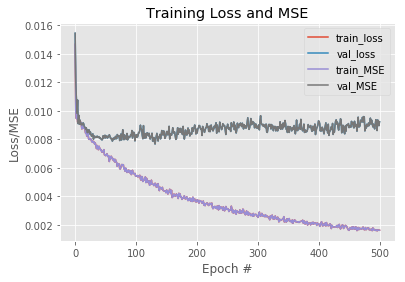

In [98]:
predictions_features = train_embeddings_network(x_short_train, y_short_train,
                                                            x_short_val, y_short_val,
                                                            0)

In [100]:
predictions_features

array([0.73394364, 0.7119759 , 0.83583724, 0.8795201 , 0.898538  ,
       0.86098945, 0.8674845 , 0.78811574, 0.88459253, 0.83331305,
       0.83285576, 0.7177451 , 0.85037446, 0.8388763 , 0.8650827 ,
       0.8211064 , 0.8459258 , 0.8140453 , 0.87871116, 0.9435627 ,
       0.7858569 , 0.8546014 , 0.7878338 , 0.8483573 , 0.7612696 ,
       0.9176791 , 0.886549  , 0.71837646, 0.84502804, 0.77901876,
       0.83957815, 0.8669695 , 0.84799266, 0.7940008 , 0.84826636,
       0.82524484, 0.8214244 , 0.6008481 , 0.7822251 , 0.87727326,
       0.77331793, 0.7417934 , 0.73456556, 0.8305613 , 0.87837344,
       0.76564085, 0.85913   , 0.7616838 , 0.82810545, 0.6101383 ,
       0.8564683 , 0.85071266, 0.78983784, 0.80138254, 0.8318457 ,
       0.92514145, 0.75796926, 0.7338023 , 0.75437236, 0.7945914 ,
       0.8107017 , 0.8144386 , 0.8049828 , 0.88440555, 0.78761923,
       0.7287202 , 0.89419836, 0.8749055 , 0.8081529 , 0.7203501 ,
       0.86624235, 0.9040447 , 0.8865241 , 0.855585  , 0.81926

In [102]:
from scipy.stats import spearmanr
spearmanr(y_short_val, predictions_features)

SpearmanrResult(correlation=0.23918097409236613, pvalue=6.354377222308723e-05)

# Feature Extraction

In [33]:
def extract_embedding_feature(df):

    print('[INFO] Loading word vectors')
    embeddings_index = load_pretrained_word_vectors()

    # CAPTIONS
    train_captions = df['description']
    train_captions = train_captions.tolist()
    caption_words = list(set([ word for caption in train_captions for word in caption.split() ]))
    print('[INFO] {:,} words in the dev captions'.format(len(caption_words)))

    # VECTORIZATION

    print('[INFO] Vectorize the captions into a 2D integer tensor...')
    # Tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_captions)
    # # Save Tokenizer
    with open(embedding_tokenizer_path, 'wb') as f:
        pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

    # Sequences
    train_sequences = tokenizer.texts_to_sequences(train_captions)
    # Padding
    word_index = tokenizer.word_index
    MAX_NUM_WORDS = len(word_index)
    MAX_SEQUENCE_LENGTH = max([ len(caption.split()) for caption in train_captions ])
    # # Save
    with open(max_sequence_length_path, 'w') as f:
        f.write(str(MAX_SEQUENCE_LENGTH))

    # X and Y TRAIN
    X_train = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)

    ## TRAINING

    if EMBEDDINGS_TRAINING:

        print('[INFO] Creating the embeddings matrix...')
        # prepare embedding matrix
        num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
        embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
        for word, i in word_index.items():
            if i > MAX_NUM_WORDS:
                continue
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # words not found in embedding index will be all-zeros.
                embedding_matrix[i] = embedding_vector
        print('[INFO] Embedding Matrix\'s shape is {}'.format(embedding_matrix.shape))

        # MODEL

        # load pre-trained word embeddings into an Embedding layer
        # note that we set trainable = False so as to keep the embeddings fixed
        embedding_layer = Embedding(num_words,
                                    EMBEDDING_DIM,
                                    embeddings_initializer=Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False)

        print('[INFO] Training GRU model...')

        sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
        embedded_sequences = embedding_layer(sequence_input)
        out = Lambda(lambda x: x)(embedded_sequences)
        model = Model(sequence_input, out)
        model.summary()
        output = model.predict(X_train)
        print(output.shape)
        print(type(output))
        return output


In [34]:
output = extract_embedding_feature(score_and_caption)

[INFO] Loading word vectors
[INFO] Loading word vectors...


D:\Enviroment\Anaconda\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  if __name__ == '__main__':


[INFO] Found 399,955 word vectors.
[INFO] 5,048 words in the dev captions
[INFO] Vectorize the captions into a 2D integer tensor...
[INFO] Creating the embeddings matrix...
[INFO] Embedding Matrix's shape is (3689, 300)
[INFO] Training GRU model...
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 86)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 86, 300)           1106700   
_________________________________________________________________
lambda_3 (Lambda)            (None, 86, 300)           0         
Total params: 1,106,700
Trainable params: 0
Non-trainable params: 1,106,700
_________________________________________________________________
(2191, 86, 300)
<class 'numpy.ndarray'>


In [35]:
output[0]

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [ 0.038466, -0.039792,  0.082747, ..., -0.33427 ,  0.011807,
         0.059703],
       [-0.014619, -0.17277 , -0.11171 , ...,  0.44198 ,  0.3939  ,
         0.15    ],
       [-0.13801 , -0.14036 , -0.26103 , ..., -0.36674 ,  0.032979,
         0.045931]], dtype=float32)

In [37]:
model_name = 'Glove_embedding'
for i in range(0, len(video_id_list)):
        if not os.path.exists(f"{FEATURES_DIR}/{model_name}/{video_id_list[i]}"):
            os.mkdir(f"{FEATURES_DIR}/{model_name}/{video_id_list[i]}")
        
        feature_path = f"{FEATURES_DIR}/{model_name}/{video_id_list[i]}/{video_id_list[i]}_{sub_id_list[i]}.csv"
        if not os.path.exists(feature_path):
            np.savetxt(feature_path, output[i], delimiter=',')